This notebook loads the key comparisons with PCAT and DAOPHOT from our paper. 

To produce the StarNet fits, run 
```
./train_wake_sleep.py
```
in the `./experiments_m2/` folder. 

In [1]:
import numpy as np
import torch

import json

import matplotlib.pyplot as plt

import deblending_runjingdev.simulated_datasets_lib as simulated_datasets_lib
import deblending_runjingdev.sdss_dataset_lib as sdss_dataset_lib
import deblending_runjingdev.starnet_lib as starnet_lib
import deblending_runjingdev.sleep_lib as sleep_lib
import deblending_runjingdev.image_statistics_lib as image_statistics_lib
import deblending_runjingdev.daophot_catalog_lib as daophot_catalog_lib

import deblending_runjingdev.plotting_utils as plotting_utils

from deblending_runjingdev.which_device import device

np.random.seed(34534)
_ = torch.manual_seed(94219)

# Load the m2 subregion

This is the 100 x 100 subregion considered in the main text of our paper. 

In [2]:
sdss_image, sdss_background, hubble_locs, hubble_fluxes, sdss_data, wcs = \
    sdss_dataset_lib.load_m2_data()

loading sdss image from ../../sdss_stage_dir/2583/2/136/frame-r-002583-2-0136.fits
loading sdss image from ../../sdss_stage_dir/2583/2/136/frame-i-002583-2-0136.fits
loading hubble data from  ../hubble_data/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt
getting sdss coordinates from:  ../../sdss_stage_dir/2583/2/136/frame-r-002583-2-0136.fits

 aligning images. 
 Getting sdss coordinates from:  ../../sdss_stage_dir/2583/2/136/frame-i-002583-2-0136.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]



 returning image at x0 = 630, x1 = 310


In [3]:
nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'][0].mean()

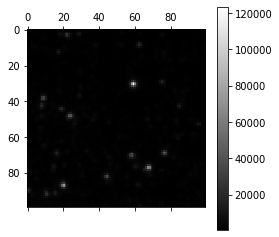

In [4]:
# the subimage of M2 considered in our paper
plt.matshow(sdss_image[0].cpu(), cmap = plt.cm.gray)
plt.colorbar()

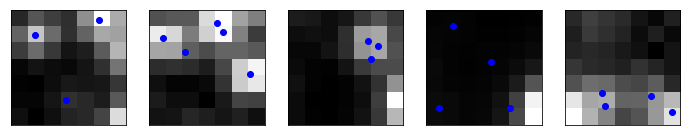

In [5]:
# a few example patches. 
# blue are hubble locations

f, axarr = plt.subplots(1, 5, figsize=(12, 6))

for i in range(5): 
    plotting_utils.plot_subimage(axarr[i], 
                                 sdss_image[0],
                                 None, 
                                 hubble_locs, 
                                 x0 = int(np.random.choice(100, 1)), 
                                 x1 = int(np.random.choice(100, 1)), 
                                 patch_slen = 7)
    axarr[i].set_xticks([]);
    axarr[i].set_yticks([]);
    


# Load StarNet fits

In [6]:
# sleep only encoder
star_encoder = starnet_lib.StarEncoder(slen = 100,
                                       ptile_slen = 8,
                                       step = 2,
                                       edge_padding = 3, 
                                       n_bands = 2,
                                       max_detections = 2)

star_encoder.load_state_dict(torch.load('../fits/starnet', 
                               map_location=lambda storage, loc: storage))


star_encoder.eval(); 
star_encoder.to(device);

starnet_map_locs, starnet_map_fluxes, starnet_map_n_stars = \
    star_encoder.sample_star_encoder(sdss_image.unsqueeze(0).to(device), 
                                    return_map_n_stars = True, 
                                    return_map_star_params = True)[0:3]

In [7]:
# wake-sleep encoder
star_encoder_ws = starnet_lib.StarEncoder(slen = 100,
                                            ptile_slen = 8,
                                            step = 2,
                                            edge_padding = 3, 
                                            n_bands = 2,
                                            max_detections = 2)

star_encoder_ws.load_state_dict(torch.load('../fits/starnet-encoder-iter2', 
                               map_location=lambda storage, loc: storage))


star_encoder_ws.eval(); 
star_encoder_ws.to(device);

starnet_ws_map_locs, starnet_ws_map_fluxes, starnet_ws_map_n_stars = \
    star_encoder_ws.sample_star_encoder(sdss_image.unsqueeze(0).to(device), 
                                    return_map_n_stars = True, 
                                    return_map_star_params = True)[0:3]

# Load chain from PCAT

In [8]:
chain_results = np.load('../fits/my_chain_nsamp3000.npz')

In [9]:
# we take the last 300 samples of the chain
pcat_n_samples = 300

In [10]:
gain = sdss_data[0]['gain'][0]

In [11]:
# n_samples x max_stars x n_bands
pcat_sampled_fluxes = chain_results['f'][:, -pcat_n_samples:, :].transpose([1, 2, 0]) * gain

# get boolean for stars that are on
pcat_is_on_sampled = pcat_sampled_fluxes[:, :, 0] > 0
assert (pcat_is_on_sampled.sum(1) == chain_results['n'][-pcat_n_samples:]).all()

# locations: n_samples x max_stars x 2
pcat_sampled_locs = np.dstack((chain_results['y'][-pcat_n_samples:, :], 
                                    chain_results['x'][-pcat_n_samples:, :]))

# covert everything to torch tensors 
pcat_sampled_locs = torch.Tensor(pcat_sampled_locs).to(device) / (sdss_image.shape[-1] - 1)
pcat_sampled_fluxes = torch.Tensor(pcat_sampled_fluxes).to(device)

In [12]:
pcat_sampled_nstars = chain_results['n'][-pcat_n_samples:]

# Load DAOPHOT catalog

In [13]:
_daophot_locs, _daophot_fluxes = daophot_catalog_lib.load_daophot_results('../daophot_data/m2_2583.phot', 
                                                                            nelec_per_nmgy, 
                                                                            wcs)

# align the estimated locations ... 
# we do so by matching with true stars. 
# might have been a slightly different coordinate system?
daophot_locs, daophot_fluxes = daophot_catalog_lib.align_daophot_locs(_daophot_locs,
                                                                      _daophot_fluxes, 
                                                                      hubble_locs,
                                                                      hubble_fluxes[:, 0])

# Get performance metrics

In [14]:
mag_vec = np.concatenate((np.array([15]), 
                          np.arange(19, 22.2, 0.4), 
                          np.array([100])))

In [15]:
def get_summary_statistics(est_locs, est_fluxes): 
    
    # get tpr and ppv as function of magnitude
    tpr_vec = image_statistics_lib.get_tpr_vec(est_locs,
                                               hubble_locs, 
                                               sdss_image.shape[-1], 
                                               est_fluxes, 
                                               hubble_fluxes[:, 0],
                                               nelec_per_nmgy, 
                                               mag_vec = mag_vec)[0]
    
    ppv_vec = image_statistics_lib.get_ppv_vec(est_locs,
                                               hubble_locs, 
                                               sdss_image.shape[-1], 
                                               est_fluxes, 
                                               hubble_fluxes[:, 0],
                                               nelec_per_nmgy, 
                                               mag_vec = mag_vec)[0]
    
    # get overal tpr and ppv    
    tpr, ppv = \
        image_statistics_lib.get_summary_stats(est_locs,
                                               hubble_locs, 
                                               sdss_image.shape[-1], 
                                               est_fluxes, 
                                               hubble_fluxes[:, 0],
                                               nelec_per_nmgy)[0:2]
    # f1 score 
    f1 = 2 * (tpr * ppv) / (tpr + ppv)
    return tpr, ppv, f1, tpr_vec, ppv_vec

### sleep phase metrics

In [16]:
tpr, ppv, f1, starnet_tpr_vec, starnet_ppv_vec = \
    get_summary_statistics(starnet_map_locs.squeeze(0), 
                           starnet_map_fluxes[0, :, 0])

print('StarNet-S tpr', tpr)
print('StarNet-S ppv', ppv)
print('StarNet-S f1', f1)

StarNet-S tpr tensor(0.5102, device='cuda:6')
StarNet-S ppv tensor(0.4693, device='cuda:6')
StarNet-S f1 tensor(0.4889, device='cuda:6')


### wake-sleep metrics

In [17]:
tpr, ppv, f1, starnet_ws_tpr_vec, starnet_ws_ppv_vec = \
    get_summary_statistics(starnet_ws_map_locs.squeeze(0), 
                           starnet_ws_map_fluxes[0, :, 0])

print('StarNet-WS tpr', tpr)
print('StarNet-WS ppv', ppv)
print('StarNet-WS f1', f1)

StarNet-WS tpr tensor(0.5059, device='cuda:6')
StarNet-WS ppv tensor(0.6008, device='cuda:6')
StarNet-WS f1 tensor(0.5493, device='cuda:6')


### PCAT metrics

These are averaged over all the samples

In [18]:
tpr = 0.
ppv = 0.
f1 = 0.

pcat_ppv_vec = torch.zeros(len(mag_vec) - 1)
pcat_tpr_vec = torch.zeros(len(mag_vec) - 1)

for i in range(pcat_n_samples):
    is_on = pcat_is_on_sampled[i]
    
    tpr_i, ppv_i, f1_i, pcat_tpr_vec, pcat_ppv_vec = \
        get_summary_statistics(pcat_sampled_locs[i, is_on, :], 
                               pcat_sampled_fluxes[i, is_on, 0])
    
    pcat_tpr_vec += pcat_tpr_vec / pcat_n_samples
    pcat_ppv_vec += pcat_ppv_vec / pcat_n_samples
    
    tpr += tpr_i / pcat_n_samples
    ppv += ppv_i / pcat_n_samples
    f1 += f1_i / pcat_n_samples

print('PCAT tpr', tpr)
print('PCAT ppv', ppv)
print('PCAT f1', f1)

PCAT tpr tensor(0.5591, device='cuda:6')
PCAT ppv tensor(0.4046, device='cuda:6')
PCAT f1 tensor(0.4694, device='cuda:6')


### DAOPHOT metrics

In [19]:
tpr, ppv, f1, daophot_tpr_vec, daophot_ppv_vec = \
    get_summary_statistics(daophot_locs, 
                           daophot_fluxes.squeeze())

print('DAOPHOT tpr', tpr)
print('DAOPHOT ppv', ppv)
print('DAOPHOT f1', f1)

DAOPHOT tpr tensor(0.1998, device='cuda:6')
DAOPHOT ppv tensor(0.6305, device='cuda:6')
DAOPHOT f1 tensor(0.3034, device='cuda:6')


## Plot metrics as function of magnitude

In [20]:
axis_label_size = 20
ticksize = 12
legendsize = 12
markersize = 10
linewidth = 2
titlesize = 18

In [21]:
def plot_summary_vec(summary_vec, ax, marker, color, label): 
    ax.plot(x_tmp[:-1],
            summary_vec,
            marker, 
            markersize = markersize, 
            linewidth = linewidth, 
            color = color, 
            label = label)

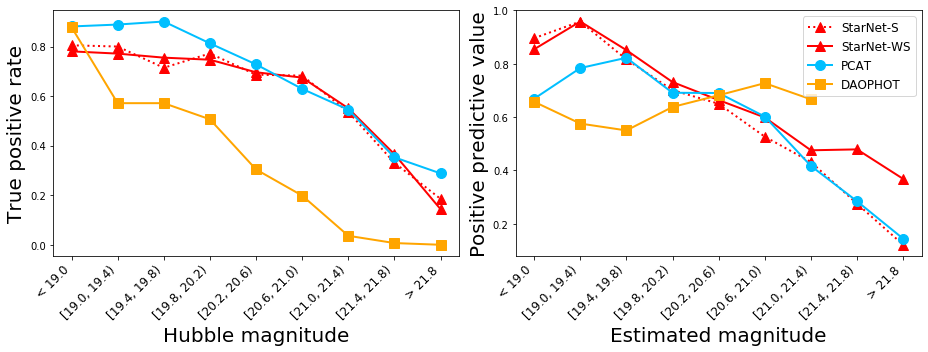

In [22]:
fig, axarr = plt.subplots(1, 2, figsize=(13, 5))

x_tmp = np.arange(len(mag_vec))

############### 
# true positive rates
###############
plot_summary_vec(starnet_tpr_vec, 
                 axarr[0], 
                 marker = ':^', 
                 color = 'r', 
                 label = 'StarNet-S')

plot_summary_vec(starnet_ws_tpr_vec, 
                 axarr[0], 
                 marker = '-^', 
                 color = 'r', 
                 label = 'StarNet-WS')

plot_summary_vec(pcat_tpr_vec, 
                 axarr[0], 
                 marker = '-o', 
                 color = 'deepskyblue', 
                 label = 'PCAT')

plot_summary_vec(daophot_tpr_vec, 
                 axarr[0], 
                 marker = '-s', 
                 color = 'orange', 
                 label = 'DAOPHOT')

################
# positive predictive values
###############
plot_summary_vec(starnet_ppv_vec, 
                 axarr[1], 
                 marker = ':^', 
                 color = 'r', 
                 label = 'StarNet-S')

plot_summary_vec(starnet_ws_ppv_vec, 
                 axarr[1], 
                 marker = '-^', 
                 color = 'r', 
                 label = 'StarNet-WS')

plot_summary_vec(pcat_ppv_vec, 
                 axarr[1], 
                 marker = '-o', 
                 color = 'deepskyblue', 
                 label = 'PCAT')

# no detection at lower magnitudes. 
# don't plot them
daophot_ppv_vec[daophot_ppv_vec == 0] = np.inf
plot_summary_vec(daophot_ppv_vec, 
                 axarr[1], 
                 marker = '-s', 
                 color = 'orange', 
                 label = 'DAOPHOT')

###############
# Legend
###############
axarr[1].legend(prop={'size': legendsize})

###############
# axis labels
###############
axarr[0].set_xlabel('Hubble magnitude', fontsize = axis_label_size)
axarr[1].set_xlabel('Estimated magnitude', fontsize = axis_label_size)
axarr[0].set_ylabel('True positive rate', fontsize = axis_label_size)
axarr[1].set_ylabel('Positive predictive value', fontsize = axis_label_size)


labels_raw = np.round(mag_vec, 1)
labels = ['[' + str(labels_raw[i]) + ', ' + str(labels_raw[i+1]) + ')' for i in range(len(labels_raw) - 1)]

labels[0] = '< ' + str(labels_raw[1])
labels[-1] = '> ' + str(labels_raw[-2])

for i in range(2): 
    axarr[i].set_xticks(x_tmp[:-1])
    axarr[i].set_xticklabels(labels, rotation=45, ha = 'right', 
                             fontsize = axis_label_size * 0.6)

fig.tight_layout()

fig.savefig('../../figures/m2_results/summary_statistics_m2.png')

# Example subimages 

In [23]:
def add_points(fig, est_locs, x0, x1, subimage_slen, color = 'c', marker = 'x', alpha = 1.0): 
    slen = sdss_image.shape[-1]
    
    _est_locs = est_locs * (slen - 1)
    which_locs = (_est_locs[:, 0] > x0) & \
                    (_est_locs[:, 0] < (x0 + subimage_slen - 1)) & \
                    (_est_locs[:, 1] > x1) & \
                    (_est_locs[:, 1] < (x1 + subimage_slen - 1))
    shift = torch.Tensor([[x0, x1]]).to(device)
    locs_filtered = (_est_locs[which_locs, :] - shift).cpu()
    fig.scatter(locs_filtered[:, 1], locs_filtered[:, 0], color = color, marker = marker, alpha = alpha)


In [24]:
def plot_detections(ax, fig, est_locs, x0, x1, color, marker, alpha = 1.0): 
    band = 0
    subimage_slen = 10
    
    # plot hubble locations
    _ = plotting_utils.plot_subimage(ax,
                                     sdss_image[band], 
                                     None, 
                                     hubble_locs, 
                                     x0, 
                                     x1, 
                                     subimage_slen, 
                                     add_colorbar = True, 
                                     global_fig = fig)
    
    # plot estimated locations
    add_points(ax, est_locs, 
               x0, 
               x1, 
               subimage_slen, 
               color = color, 
               marker = marker, 
               alpha = alpha)
    
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

### Example detections form Starnet-WS

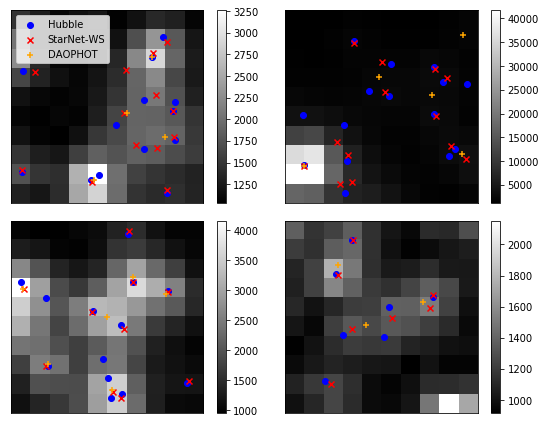

In [25]:
fig, axarr = plt.subplots(2, 2, figsize=(8, 6))

# location of patches
x0_vec = [53, 41, 31, 33] 
x1_vec = [70, 23, 82, 64]

for i in range(len(x0_vec)): 
    x0 = x0_vec[i]
    x1 = x1_vec[i]
    
    # plot starnet detctions
    plot_detections(axarr[i // 2, i % 2], 
                    fig, 
                    starnet_ws_map_locs.squeeze(), 
                    x0, 
                    x1, 
                    color = 'red', 
                    marker = 'x')
    
    # plot DAOPHOT as well
    add_points(axarr[i // 2, i % 2], 
               daophot_locs, 
               x0,
               x1,
               subimage_slen = 10, 
               color = 'orange', 
               marker = '+')
    
    if i == 0: 
        axarr[i // 2, i % 2].legend(['Hubble', 'StarNet-WS', 'DAOPHOT'], loc = 'upper left')

fig.tight_layout()

fig.savefig('../../figures/m2_results/example_subimages_ws.png')

### Example detections from PCAT

Plot just one sample

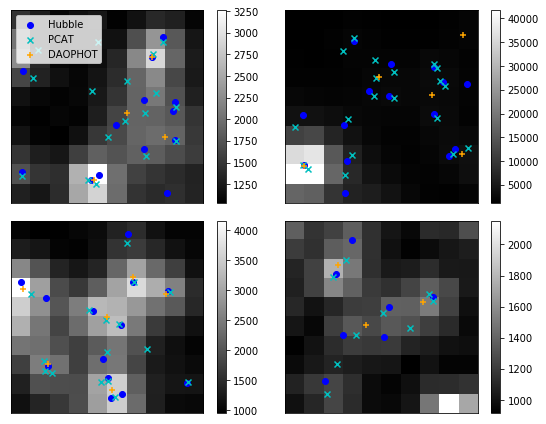

In [26]:
fig, axarr = plt.subplots(2, 2, figsize=(8, 6))

for i in range(len(x0_vec)): 
    x0 = x0_vec[i]
    x1 = x1_vec[i]
    
    # plot pcat detections
    plot_detections(axarr[i // 2, i % 2], 
                    fig,
                    pcat_sampled_locs[-1].squeeze(), 
                    x0, 
                    x1, 
                    color = 'c', 
                    marker = 'x')
    
    # plot DAOPHOT
    add_points(axarr[i // 2, i % 2], 
               daophot_locs, 
               x0,
               x1,
               subimage_slen = 10, 
               color = 'orange', marker = '+')
    
    if i == 0: 
        axarr[i // 2, i % 2].legend(['Hubble', 'PCAT', 'DAOPHOT'], loc = 'upper left')

fig.tight_layout()

fig.savefig('../../figures/m2_results/example_subimages_pcat.png')

# Check out uncertainties

### Plot some wake-sleep samples 

In [27]:
# sample from wake-sleep
_samples = 300
ws_sampled_locs, ws_sampled_fluxes, ws_sampled_n_stars = \
    star_encoder_ws.sample_star_encoder(sdss_image.unsqueeze(0), 
                                        return_map_n_stars = False, 
                                        return_map_star_params = False, 
                                        n_samples = n_samples)[0:3]

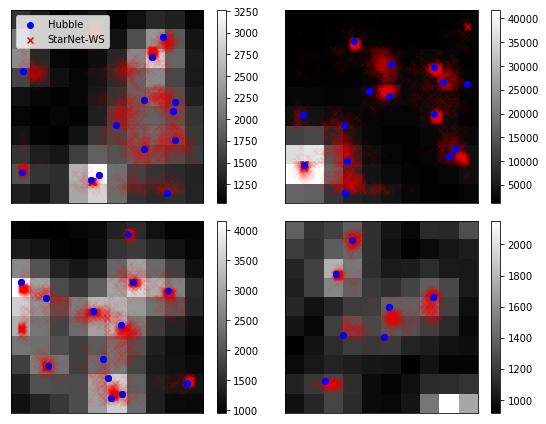

In [28]:
fig, axarr = plt.subplots(2, 2, figsize=(8, 6))

for i in range(len(x0_vec)): 
    x0 = x0_vec[i]
    x1 = x1_vec[i]
    
    # plot starnet samples
    plot_detections(axarr[i // 2, i % 2], 
                    fig, 
                    ws_sampled_locs.reshape(-1, 2),  
                    x0, 
                    x1, 
                    color = 'red', 
                    marker = 'x', 
                    alpha = 0.05)
    
    # plot hubble locations again, so its on top
    add_points(axarr[i // 2, i % 2],
               hubble_locs, 
               x0, 
               x1,
               subimage_slen = 10, 
               color = 'blue', marker = 'o')
    
    if i == 0: 
        leg = axarr[i // 2, i % 2].legend(['Hubble', 'StarNet-WS'], loc = 'upper left')
        
        # fix legend alpha 
        for lh in leg.legendHandles: 
            lh.set_alpha(1)

        
fig.tight_layout()

fig.savefig('../../figures/m2_results/example_subimages_samples_ws.png')

### Plot samples from PCAT

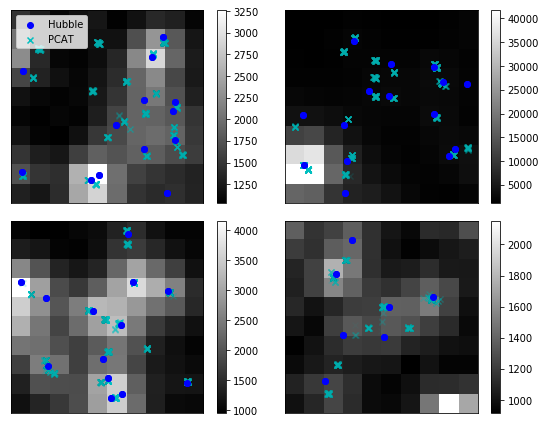

In [29]:
fig, axarr = plt.subplots(2, 2, figsize=(8, 6))

for i in range(len(x0_vec)): 
    x0 = x0_vec[i]
    x1 = x1_vec[i]
    
    # plot pcat samples
    plot_detections(axarr[i // 2, i % 2], 
                    fig, 
                    pcat_sampled_locs.reshape(-1, 2),  
                    x0, 
                    x1, 
                    color = 'c', 
                    marker = 'x', 
                    alpha = 0.05)
    
    # plot hubble detections
    add_points(axarr[i // 2, i % 2], 
               hubble_locs, 
               x0,
               x1, 
               subimage_slen = 10, 
               color = 'blue', marker = 'o')
    if i == 0: 
        leg = axarr[i // 2, i % 2].legend(['Hubble', 'PCAT'], loc = 'upper left')
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
            
fig.tight_layout()

fig.savefig('../../figures/m2_results/example_subimages_samples_pcat.png')

# Check out StarNet z-scores

In [30]:
# get image tiles and parameters on tiles
image_ptiles, true_tile_locs, true_tile_fluxes, \
    true_tile_n_stars, true_is_on_array = \
        star_encoder_ws.get_image_ptiles(sdss_image.unsqueeze(0), 
                                         hubble_locs.unsqueeze(0), 
                                         hubble_fluxes.unsqueeze(0), 
                                         clip_max_stars = True)

In [31]:
# Note that these variational parameters are estimated using the true number of stars!
tile_loc_mean, tile_loc_log_var, \
    tile_log_flux_mean, tile_log_flux_log_var, tile_log_probs = \
        star_encoder(image_ptiles, true_tile_n_stars)

In [32]:
# permute true parameters 
def permute_params(locs, fluxes, perm): 
    batchsize = perm.shape[0]
    max_stars = perm.shape[1]
    
    n_bands = fluxes.shape[-1]

    locs_perm = torch.zeros((batchsize, max_stars, 2))
    fluxes_perm = torch.zeros((batchsize, max_stars, n_bands))
    seq_tensor = torch.LongTensor([i for i in range(batchsize)])

    for i in range(max_stars):
        locs_perm[:, i, :] = locs[seq_tensor, perm[:, i], :]
        fluxes_perm[:, i, :] = fluxes[seq_tensor, perm[:, i], :]
        
    return locs_perm, fluxes_perm

In [33]:
# get the minimizing permutation
_, _, _, _, perm_indx = \
    sleep_lib.get_inv_kl_loss(star_encoder, 
                                sdss_image.unsqueeze(0), 
                                hubble_locs.unsqueeze(0), 
                                hubble_fluxes.unsqueeze(0))[0:5]

In [34]:
from itertools import permutations

perm_list = []
for perm in permutations(range(star_encoder.max_detections)):
    perm_list.append(perm)
    
perm = np.zeros((image_ptiles.shape[0], star_encoder.max_detections))
for i in range(image_ptiles.shape[0]): 
    perm[i, :] = perm_list[perm_indx[i]]

In [35]:
# permute the variatoinal parameters 
# so they match with the true detections
locs_perm, log_fluxes_perm = permute_params(tile_loc_mean, tile_log_flux_mean, perm)
log_var_locs_perm, log_var_log_fluxes_perm = \
    permute_params(tile_loc_log_var, tile_log_flux_log_var, perm)

In [36]:
import scipy as sp

In [37]:
axis_label_size = 16
ticksize = 12
legendsize = 12
markersize = 10
linewidth = 2
titlesize = 18

In [38]:
def plot_zscores(est, logvar, truth, ax): 
    est = est[est > 0].cpu()    
    est_sd = torch.exp(0.5 * logvar[truth > 0])
    
    truth = truth[truth > 0].cpu()
    
    zscore = ((est - truth) / est_sd).detach().cpu().numpy()
    
    # histogram of z-scores
    ax.hist(zscore, 
            bins = np.linspace(-5, 5, 50), 
            density = True, 
            color = 'lightblue', 
            edgecolor='white');
    
    # plot normal density 
    x = np.linspace(zscore.min(), zscore.max(), 100)
    ax.plot(x, sp.stats.norm.pdf(x), color = 'k')
    
    ax.set_xlabel('z-score', fontsize = axis_label_size)
    
    ax.set_xlim(-5, 5)

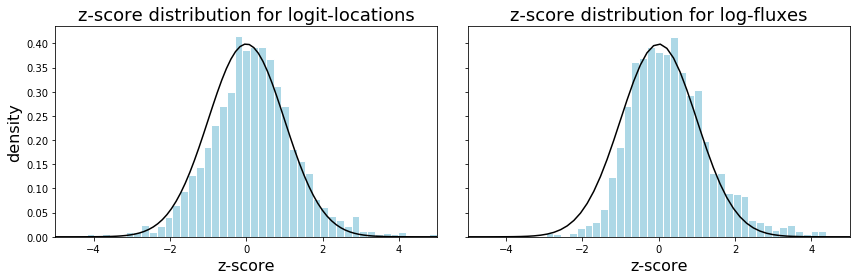

In [39]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 4), sharey = True)

plot_zscores(locs_perm, 
             log_var_locs_perm,
             true_tile_locs, 
             axarr[0])
axarr[0].set_title('z-score distribution for logit-locations', fontsize = titlesize)
axarr[0].set_ylabel('density', fontsize = axis_label_size)

_true_logfluxes = torch.log(true_tile_fluxes + 1e-8) * (true_tile_fluxes > 0)
plot_zscores(log_fluxes_perm,
             log_var_log_fluxes_perm,
             _true_logfluxes,
             axarr[1])
axarr[1].set_title('z-score distribution for log-fluxes', fontsize = titlesize)

fig.tight_layout()

fig.savefig('../../figures/m2_results/zscore_calibration.png')

# Distribution on number of stars

In [40]:
# sample the number of stars from StarNet

# from the sleep-trained encoder
sampled_n_stars = \
    star_encoder.sample_star_encoder(sdss_image.unsqueeze(0), 
                                    return_map_n_stars = False, 
                                    return_map_star_params = False, 
                                    n_samples = 1000)[2]

# from the wake-sleep trained encoder
sampled_n_stars_ws = \
    star_encoder_ws.sample_star_encoder(sdss_image.unsqueeze(0), 
                                    return_map_n_stars = False, 
                                    return_map_star_params = False, 
                                    n_samples = 1000)[2]

In [41]:
(np.mean(sampled_n_stars.cpu().numpy()),
    np.quantile(sampled_n_stars.cpu(), 0.05), 
    np.quantile(sampled_n_stars.cpu(), 0.95))

(1292.343, 1260.0, 1324.0)

In [42]:
(np.mean(sampled_n_stars_ws.cpu().numpy()),
    np.quantile(sampled_n_stars_ws.cpu(), 0.05), 
    np.quantile(sampled_n_stars_ws.cpu(), 0.95))

(1013.172, 984.0, 1042.0)

In [43]:
(np.mean(pcat_sampled_nstars),
    np.quantile(pcat_sampled_nstars, 0.05), 
    np.quantile(pcat_sampled_nstars, 0.95))

(1672.2966666666666, 1664.0, 1680.05)

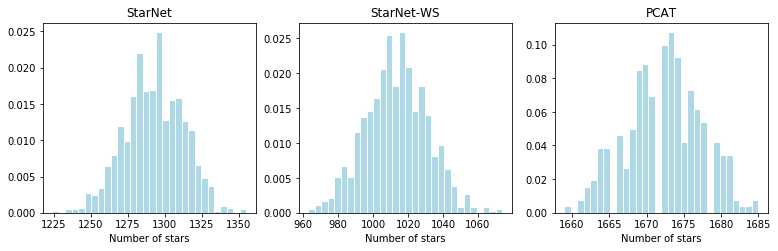

In [44]:
fig, axarr = plt.subplots(1, 3, figsize=(13, 3.5), 
                          sharey = False)

axarr[0].hist(sampled_n_stars.cpu(), 
              bins = 30, 
              color = 'lightblue', 
              edgecolor = 'white', 
              density = True);
axarr[0].set_title('StarNet')

axarr[1].hist(sampled_n_stars_ws.cpu(), 
              bins = 30, 
              color = 'lightblue', 
              edgecolor = 'white', 
              density = True);
axarr[1].set_title('StarNet-WS')

axarr[2].hist(pcat_sampled_nstars, 
              bins = 30, 
              color = 'lightblue', 
              edgecolor = 'white', 
              density = True);
axarr[2].set_title('PCAT')

for i in range(3): 
    axarr[i].set_xlabel('Number of stars')

# Flux distributions

In [45]:
# convert fluxes to magnitude
daophot_r_mag = sdss_dataset_lib.convert_nmgy_to_mag(daophot_fluxes[:, 0] / nelec_per_nmgy).cpu().numpy()
starnet_r_mag = sdss_dataset_lib.convert_nmgy_to_mag(starnet_ws_map_fluxes[0, :, 0] / nelec_per_nmgy).cpu().numpy()

tmp = pcat_sampled_fluxes[-1, :, 0] / nelec_per_nmgy
pcat_r_mag = sdss_dataset_lib.convert_nmgy_to_mag(tmp[tmp != 0]).cpu().numpy()
hubble_r_mag = sdss_dataset_lib.convert_nmgy_to_mag(hubble_fluxes[:, 0] / nelec_per_nmgy).cpu().numpy()

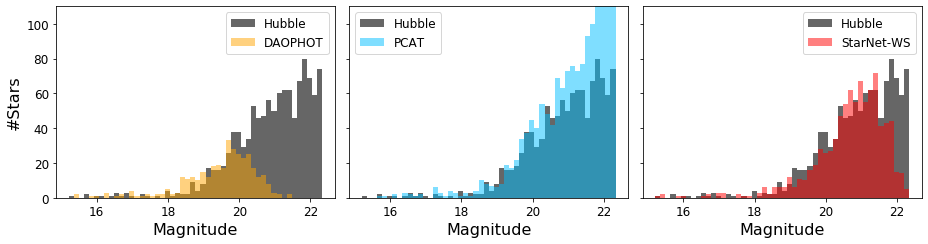

In [46]:
fig, axarr = plt.subplots(1, 3, figsize=(13, 3.5), 
                          sharey = True)

# hubble
for i in range(3): 
    foo = axarr[i].hist(hubble_r_mag, bins = 50, alpha = 0.6, 
                        label = 'Hubble', color = 'k');
    axarr[i].set_xlabel('Magnitude', fontsize = axis_label_size)

# daophot
axarr[0].hist(daophot_r_mag, alpha = 0.5, bins = foo[1], 
              label = 'DAOPHOT', color = 'orange'); 
axarr[0].legend()

# pcat
axarr[1].hist(pcat_r_mag, alpha = 0.5, bins = foo[1], 
              label = 'PCAT', color = 'deepskyblue'); 
axarr[1].legend()


# starnet
axarr[2].hist(starnet_r_mag, alpha = 0.5, bins = foo[1], 
              label = 'StarNet-WS', color = 'r'); 

for i in range(3):
    axarr[i].legend(prop={'size': legendsize})
    axarr[i].tick_params(labelsize = ticksize)
    axarr[i].set_ylim(0, 110)
    
axarr[0].set_ylabel('#Stars', fontsize = axis_label_size)
    
    
fig.tight_layout()
fig.savefig('../../figures/m2_results/luminosity_fun.png')

# Plot quality of flux estimation

In [47]:
def plot_flux_estimation(est_locs, 
                         hubble_locs, 
                         est_fluxes, 
                         hubble_fluxes, 
                         nelec_per_nmgy, 
                         ax): 
    
    # for every estimated location, find closest hubble location
    true_indx = image_statistics_lib.get_locs_error(est_locs, hubble_locs).argmin(0)
    hubble_fluxes_perm = hubble_fluxes[true_indx]
    
    # evaluate error
    est_mag = image_statistics_lib.convert_nmgy_to_mag(est_fluxes / nelec_per_nmgy)
    true_mag = image_statistics_lib.convert_nmgy_to_mag(hubble_fluxes_perm / nelec_per_nmgy)
    
    ax.scatter(est_mag.cpu(), true_mag.cpu(), 
               color = 'k', marker = 'x', alpha = 0.2)
    ax.plot(true_mag.cpu(), true_mag.cpu(), 
            color = 'red')

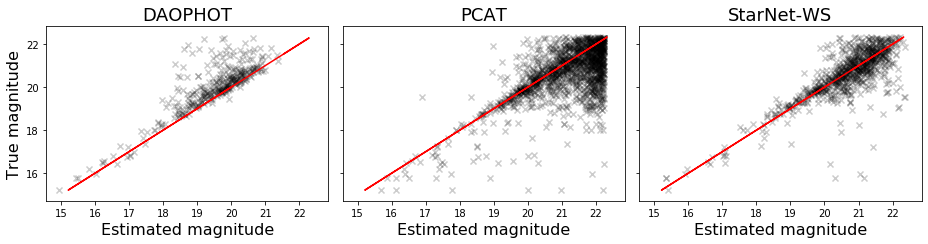

In [48]:
fig, axarr = plt.subplots(1, 3, figsize=(13, 3.5), 
                          sharey=True, 
                          sharex=True)

# daophot
plot_flux_estimation(daophot_locs, 
                     hubble_locs, 
                     daophot_fluxes, 
                     hubble_fluxes[:, 0], 
                     nelec_per_nmgy, 
                     axarr[0])


# pcat (one sample)
n = pcat_sampled_nstars[0]
plot_flux_estimation(pcat_sampled_locs[0, 0:n, :], 
                     hubble_locs, 
                     pcat_sampled_fluxes[0, 0:n, 0], 
                     hubble_fluxes[:, 0], 
                     nelec_per_nmgy, 
                     axarr[1])

# StarNet-WS
plot_flux_estimation(starnet_ws_map_locs.squeeze(0), 
                     hubble_locs, 
                     starnet_ws_map_fluxes[0, :, 0], 
                     hubble_fluxes[:, 0], 
                     nelec_per_nmgy, 
                     axarr[2])

axarr[0].set_ylabel('True magnitude', 
                    fontsize = axis_label_size)

for i in range(3): 
    axarr[i].set_xlabel('Estimated magnitude', 
                        fontsize = axis_label_size)

axarr[0].set_title('DAOPHOT', fontsize = titlesize)
axarr[1].set_title('PCAT', fontsize = titlesize)
axarr[2].set_title('StarNet-WS', fontsize = titlesize)

fig.tight_layout()

fig.savefig('../../figures/m2_results/m2_flux_estimation.png')